# Pymeos and Pyspark Partitioning Demo

First we perform the corresponding imports for the libraries to use.

In [1]:
from pymeos import *
from pysparkmeos.UDT.MeosDatatype import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.serializers import PickleSerializer
import pyspark.sql.functions as F

from pyspark.storagelevel import StorageLevel

from pysparkmeos.partitions.grid.grid_partitioner import GridPartition

from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.UDF.udf import *
from pysparkmeos.partitions.mobilityrdd import MobilityRDD

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from shapely import wkb, box
import pandas as pd
from functools import reduce

## Initialize Pymeos and setup Pyspark

In [2]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

#.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[3]") \
    .config("spark.default.parallelism", 3) \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", 1) \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.sql.allowMultipleTableArguments.enabled", True) \
    .getOrCreate()

#spark.sparkContext.setLogLevel("DEBUG")

# Append the UDT mapping to the PyMEOS classes
udt_append()

# Get the value of 'spark.default.parallelism'
print(spark.sparkContext.getConf().getAll())
#print(f"spark.default.parallelism: {default_parallelism}")
#print(f"spark.sql.allowMultipleTableArguments.enabled: {spark.sparkContext.getConf().get('spark.sql.allowMultipleTableArguments.enabled')}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 20:01:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.app.submitTime', '1715889702723'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.sql.allowMultipleTableArguments.enabled', 'true'), ('s

## Read the DataFrame and create the columns of Pymeos data objects

First, we are going to read a dataset from OpenSky, this dataset cointains the trajectory information of multiple flights within a timeframe.  

Using the latitude, longitude and timestamp we can create a PyMEOS TGeogPointInst, that in PySpark will be wrapped into a TGeogPointInstUDT object.

In [3]:
# Read data from a CSV file
data_path = "../../small_states_2022-06-27-00.csv"  # Update this with your CSV file path
#data_path = "../../sample.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True, mode='PERMISSIVE').select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon", "time", "icao24"])

    #.withColumn("Point", F.concat(F.lit("Point("), F.col("lat"), F.lit(" "), F.col("lon"), F.lit(")@"), F.col("time"))) \
# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", F.from_unixtime(F.col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("lat", F.round("lat", 2)) \
    .withColumn("lon", F.round("lon", 2)) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point")) \
    .withColumn("id", F.monotonically_increasing_id())

#    .withColumn("x", get_point_x("Point")) \
#    .withColumn("y", get_point_y("Point")) \
#    .withColumn("t", get_point_timestamp("Point")) \
# df.createOrReplaceTempView("rawPoints")

df.tail(5)

#for row in df.toLocalIterator():
#    print(row)

24/05/16 20:02:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


[Row(icao24='45fe43', time='2022-06-27 00:15:00', lat=57.28, lon=9.98, Point=TGeomPointInstWrap(POINT(9.98 57.28)@2022-06-27 00:15:00+00), x=9.979999542236328, y=57.279998779296875, t=datetime.datetime(2022, 6, 27, 0, 15), id=17180031427),
 Row(icao24='a59662', time='2022-06-27 00:15:00', lat=34.27, lon=-118.49, Point=TGeomPointInstWrap(POINT(-118.49 34.27)@2022-06-27 00:15:00+00), x=-118.48999786376953, y=34.27000045776367, t=datetime.datetime(2022, 6, 27, 0, 15), id=17180031428),
 Row(icao24='a27d26', time='2022-06-27 00:15:00', lat=35.29, lon=-98.14, Point=TGeomPointInstWrap(POINT(-98.14 35.29)@2022-06-27 00:15:00+00), x=-98.13999938964844, y=35.290000915527344, t=datetime.datetime(2022, 6, 27, 0, 15), id=17180031429),
 Row(icao24='aaa2b0', time='2022-06-27 00:15:00', lat=39.87, lon=-104.66, Point=TGeomPointInstWrap(POINT(-104.66 39.87)@2022-06-27 00:15:00+00), x=-104.66000366210938, y=39.869998931884766, t=datetime.datetime(2022, 6, 27, 0, 15), id=17180031430),
 Row(icao24='ab15c2'

In [4]:
#df.rdd.getNumPartitions()

Handling a dataset like this gives us granularity over the datapoints, but it would be better to group the trajectories together using another function, this will return the TGeogPointSeq objects representing each trajectory. Let's create a UDTF that takes the icao24, and Point, and creates a new table with icao24, and PointSeq.

In [5]:
schema = StructType([
    StructField("icao24", StringType()),
    StructField("PointSeq", TGeomPointSeqUDT())
])


@F.udf(returnType=TGeomPointSeqUDT())
def pointSeqFromPoints(pointgroup):
    if not pointgroup:
        return None
    pymeos_initialize()
    if len(pointgroup) == 1:
        pointgroup = f'[{pointgroup[0].__str__()}]'
        return TGeomPointSeq(pointgroup)
    pointgroup = sorted(pointgroup, key=lambda x: x.timestamps()[0])
    pointseq = TGeomPointSeq(instant_list=pointgroup)
    return pointseq

print(df.count())

#df.select("Point").tail(5)
df.groupBy("icao24").agg(F.count("Point").alias("cnt")).orderBy("cnt",ascending=False).show()

trajectories = df.groupBy("icao24").agg(
    F.collect_list(F.col("Point")).alias("PointSeq")
).select("icao24", "PointSeq").withColumn("PointSeq", pointSeqFromPoints("PointSeq"))

print(trajectories.count())

trajectories.show(5)
trajectories.collect()[0].PointSeq
#trajectories.rdd.getNumPartitions()

#spark.sparkContext.setCheckpointDir("./checkpoint")
#trajectories = trajectories.checkpoint()
#trajectories.tail(1).limit(1).collect()[0].PointSeq

530231


+------+---+
|icao24|cnt|
+------+---+
|4d21ea| 91|
|406471| 91|
|a20f1a| 91|
|4ca9cc| 91|
|34718e| 91|
|a04417| 91|
|ac6364| 91|
|c04aa1| 91|
|a054e1| 90|
|c05ee5| 90|
|a6cf94| 90|
|3c5430| 90|
|7c7aac| 90|
|e48d6e| 90|
|aa32e4| 90|
|ab6316| 90|
|a9f838| 90|
|a72823| 90|
|3455d9| 90|
|adbef0| 90|
+------+---+
only showing top 20 rows



7095


+------+--------------------+
|icao24|            PointSeq|
+------+--------------------+
|0100f6|[POINT(24.76 35.7...|
|010109|[POINT(51.27 26.4...|
|0101bb|[POINT(51.63 25.1...|
|0101bd|[POINT(46.74 24.8...|
|010207|[POINT(26.72 35.6...|
+------+--------------------+
only showing top 5 rows



TGeomPointSeqWrap([POINT(24.76 35.74)@2022-06-27 00:00:10+00, POINT(24.79 35.73)@2022-06-27 00:00:20+00, POINT(24.81 35.71)@2022-06-27 00:00:30+00, POINT(24.83 35.7)@2022-06-27 00:00:40+00, POINT(24.85 35.68)@2022-06-27 00:00:50+00, POINT(24.88 35.67)@2022-06-27 00:01:00+00, POINT(24.92 35.63)@2022-06-27 00:01:20+00, POINT(24.94 35.62)@2022-06-27 00:01:30+00, POINT(24.97 35.6)@2022-06-27 00:01:40+00, POINT(24.99 35.59)@2022-06-27 00:01:50+00, POINT(25.01 35.57)@2022-06-27 00:02:00+00, POINT(25.03 35.56)@2022-06-27 00:02:10+00, POINT(25.06 35.54)@2022-06-27 00:02:20+00, POINT(25.08 35.53)@2022-06-27 00:02:30+00, POINT(25.1 35.51)@2022-06-27 00:02:40+00, POINT(25.12 35.5)@2022-06-27 00:02:50+00, POINT(25.14 35.48)@2022-06-27 00:03:00+00, POINT(25.15 35.48)@2022-06-27 00:03:10+00, POINT(25.17 35.47)@2022-06-27 00:03:20+00, POINT(25.2 35.45)@2022-06-27 00:03:30+00, POINT(25.2 35.45)@2022-06-27 00:08:20+00, POINT(25.9 34.96)@2022-06-27 00:08:50+00, POINT(25.94 34.94)@2022-06-27 00:09:00+00,

This has reduced the table from 530k Points to 7k PointSeq!

In [6]:
# trajectories.createOrReplaceTempView("trajectories")

Now we need to calculate the boundaries of the whole space of trajectories.

In [7]:
from pymeos import TPoint

@F.udf(returnType=STBoxUDT())
def point_to_stbox(tpoint: TPoint) -> STBox:
    pymeos_initialize()
    return tpoint.bounding_box()

trajectories = trajectories.withColumn("STBox", point_to_stbox("PointSeq")).withColumn("seqId", F.monotonically_increasing_id())
trajectories.createOrReplaceTempView("trajectories")
trajectories.show(truncate=False)
trajectories.cache()
print(trajectories.count())
#trajectories.rdd.getNumPartitions()

24/05/16 20:05:30 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 23 (TID 31): Attempting to kill Python Worker


+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

7095


In [8]:
# df.select("Point").write.mode("overwrite").csv("../../small_states_2022-06-27-00_only_points")

# df.show(3, truncate=False)

@F.udf(returnType=FloatType())
def get_box_dim(box: STBox, dim: str, category: str):
    pymeos_initialize()
    try:
        if dim == 'x':
            if category == 'max':
                return box.xmax()
            else:
                return box.xmin()
        if dim == 'y':
            if category == 'max':
                return box.ymax()
            else:
                return box.ymin()
        if dim == 'z':
            if category == 'max':
                return box.zmax()
            else:
                return box.zmin()
    except:
        return None

@F.udf(returnType=TimestampType())
def get_box_time(box: STBox, category: str):
    pymeos_initialize()
    try:
        if category=='max':
            return box.tmax()
        else:
            return box.tmin()
    except:
        return None

schema = StructType([
    StructField("bounds", STBoxUDT())
])

def bounds_calculate_map(index, partition_rows):
    pymeos_initialize("UTC")
    aggregator = TemporalPointExtentAggregator.start_aggregation()
    for row in partition_rows:
        seq = TGeomPointSeq(row.PointSeq.__str__())
        aggregator.add(seq)
    boundbox = STBoxWrap(aggregator.aggregation().__str__())
    #print(boundbox, type(boundbox))
    return [(1, boundbox)]


def bounds_calculate_reduce(bounds1, bounds2):
    pymeos_initialize("UTC")
    #aggregation = TemporalPointExtentAggregator.start_aggregation()
    #aggregation.add(bounds1[1])
    #aggregation.add(bounds2[1])
    if type(bounds1) == tuple:
        #print(bounds1[1], bounds2[1])
        aggregation = bounds1[1] + bounds2[1]
    else:
        aggregation = bounds1 + bounds2[1]
    boundbox = STBoxWrap(aggregation.__str__())
    #print(boundbox, type(boundbox))
    return boundbox


bounds = trajectories.rdd.mapPartitionsWithIndex(bounds_calculate_map).reduce(bounds_calculate_reduce)
bounds
#boundsdf = spark.sql("""
#    SELECT * 
#    FROM BoundsCalculator6(
#        TABLE(
#            SELECT STBox AS bounds FROM trajectories
#        )
#    )
#""")

#boundsdf.show()

#boundsdf = trajectories.agg(
#        F.max(get_box_dim("STBox", F.lit("x"), F.lit("max"))).alias("xmax"),
#        F.min(get_box_dim("STBox", F.lit("x"), F.lit("min"))).alias("xmin"),
#        F.max(get_box_dim("STBox", F.lit("y"), F.lit("max"))).alias("ymax"),
#        F.min(get_box_dim("STBox", F.lit("y"), F.lit("min"))).alias("ymin"),
#        F.max(get_box_time("STBox", F.lit("max"))).alias("tmax"),
#        F.min(get_box_time("STBox", F.lit("min"))).alias("tmin"),
#    ).select(bounds_as_box("xmin", "xmax", "ymin", "ymax", "tmin", "tmax").alias("bounds"))


#boundsdf = df.agg(
#    F.max(F.col("x")).alias("max_x"),
#    F.min(F.col("x")).alias("min_x"),
#    F.max(F.col("y")).alias("max_y"),
#    F.min(F.col("y")).alias("min_y"),
#    F.max(F.col("t").cast("timestamp")).alias("max_t"),
#    F.min(F.col("t").cast("timestamp")).alias("min_t")
#).select(bounds_as_box("min_x", "max_x", "min_y", "max_y", "min_t", "max_t").alias("bounds"))

#boundsdf.show(truncate=False)
# bounds = STBoxWrap(boundsdf.collect()[0].bounds.__str__(), geodetic=True)
#bounds = STBoxWrap('STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])')
#boundsdf.unpersist()
#df.unpersist()
# bounds

STBoxWrap(STBOX XT(((-177.03,-46.42),(177.82,70.3)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00]))

In [9]:
#bounds = STBoxWrap(
#        "SRID=0;STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])",
#        geodetic=False)
#bounds

## Generate the partitioning scheme and repartition data

In [10]:
# Now we calculate the grid and partition accordingly
gp = GridPartition(cells_per_side=3, bounds=bounds)
grid = gp.as_spark_table()
grid.cache()
grid.show()
grid.createOrReplaceTempView("grid")
#grid.rdd.getNumPartitions()

+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-177.0...|
|     1|STBOX XT(((-177.0...|
|     2|STBOX XT(((-177.0...|
|     3|STBOX XT(((-177.0...|
|     4|STBOX XT(((-177.0...|
|     5|STBOX XT(((-177.0...|
|     6|STBOX XT(((-177.0...|
|     7|STBOX XT(((-177.0...|
|     8|STBOX XT(((-177.0...|
|     9|STBOX XT(((-58.74...|
|    10|STBOX XT(((-58.74...|
|    11|STBOX XT(((-58.74...|
|    12|STBOX XT(((-58.74...|
|    13|STBOX XT(((-58.74...|
|    14|STBOX XT(((-58.74...|
|    15|STBOX XT(((-58.74...|
|    16|STBOX XT(((-58.74...|
|    17|STBOX XT(((-58.74...|
|    18|STBOX XT(((59.536...|
|    19|STBOX XT(((59.536...|
+------+--------------------+
only showing top 20 rows



24/05/16 20:11:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
from pyspark.sql.types import Row
from typing import Iterator

schema = StructType([
    StructField("trajectoryId", IntegerType()),
    StructField("partitionKey", IntegerType()),
    StructField("trajectory", TGeogPointSeqUDT())
])

@F.udtf(returnType=schema)
class RegularPartition:
    def eval(self, row: Row):
        pymeos_initialize()
        sequence_id = row.seqId
        trajectory = row.trajectory
        #print(trajectory,type(trajectory))
        #print(row.grid[0])
        #grid = [STBoxWrap(f"SRID=4326;{tile.__str__().strip('SRID=4326;')}") for tile in row.grid]
        grid = row.grid
        partitioned = [(key, trajectory.at(tile)) for key, tile in enumerate(grid)]
        #print(trajectory)
        #print(grid)
        #print(partitioned)
        count = 0
        responses = []
        for partition_key, partition_traj in partitioned:
            count += 1
            if partition_traj is None:
                continue
            else:
                #responses.append((sequence_id, partition_key, partition_traj,))
                seqs = partition_traj.segments()
                #print(seqs)
                for partition_traj_seq in seqs:
                    responses.append((sequence_id, partition_key, partition_traj_seq,))
        for response in responses:
            yield response


spark.udtf.register("regularPartition", RegularPartition)

# spark.sql("SELECT collect_list(tile) FROM grid").show()

#spark.sql("SELECT seqId, PointSeq AS trajectory, (SELECT collect_list(tile) FROM grid) AS grid FROM trajectories").collect()

trajectoriesPartMap = spark.sql("""
    SELECT * 
    FROM regularPartition(
        TABLE(
                SELECT seqId, PointSeq AS trajectory, (SELECT collect_list(tile) FROM grid) AS grid
                FROM trajectories
        )
    )
""")
trajectoriesPartMap.cache()
trajectoriesPartMap.show()

#trajectoriesPartMap.createOrReplaceTempView("trajectoriesPartMap")

#spark.sql(f"""
#    CREATE TABLE trajectoriesPart
#    USING parquet
#    PARTITIONED BY (partitionKey)
#    AS SELECT * FROM trajectoriesPartMap
#""")

#num_partitions = gp.num_partitions()

#trajectoriesPart = spark.table("trajectoriesPart").rdd.map(lambda row: (row['partitionKey'], row)).partitionBy(num_partitions)
#spark.sparkContext.setLogLevel("WARN")

#print(trajectoriesPartMap.tail(1))
#print(trajectoriesPartMap.count())
#trajectoriesPartMap.createOrReplaceTempView("trajectoriesPartMap")
#print(trajectoriesPartMap.rdd.getNumPartitions())
num_partitions = gp.num_partitions()
#trajectoriesPartMap = trajectoriesPartMap.withColumn("trajectory", F.col("trajectory").cast("string"))
trajectoriesPartMap.printSchema()

#trajectoriesPartMap = trajectoriesPartMap.repartition(num_partitions, "partitionKey")

trajectoriesPartMapRdd = trajectoriesPartMap.rdd.map(lambda row: (row['partitionKey'], row)).partitionBy(num_partitions)
#for row in trajectoriesPartMapRdd.take(1):
#    print(row)

#trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]) #.withColumn("trajectory", F.col("trajectorydata.trajectory").cast(TGeogPointSeqUDT())).withColumn("trajectoryId", F.col("trajectorydata.trajectoryId")).drop("trajectorydata")
#trajectoriesPartMap.printSchema()
#trajectoriesPart.groupBy("trajectoryId").agg(F.count(F.col("trajectory")).alias("cnt")).orderBy("cnt", ascending=False).show()
#trajectoriesPartMap.orderBy("trajectoryId")
#trajectoriesPartMap.show()
#print(trajectoriesPartMap.rdd.getNumPartitions())

#RegularPartition(trajectories, trajectories.select("PointSeq"), F.lit(gp.gridstr)).show()


#spark.udtf.register("regularPartition", RegularPartition)


#print(gp.num_partitions())
#num_partitions = gp.num_partitions()
#gridstr = gp.gridstr

# Register the udf
#get_partition_key_udf = udf(gp.get_partition, IntegerType())

#dfpoint = df.select("id", "Point", "PointStr").withColumn("partitionKey", get_partition_key_udf(col("Point"), lit(gridstr)))
#dfpoint.show()

# dfpoint.select("_metadata").show(truncate=False)

+------------+------------+--------------------+
|trajectoryId|partitionKey|          trajectory|
+------------+------------+--------------------+
|           0|           3|[POINT(-88.29 13....|
|           0|           4|[POINT(-88.29 13....|
|           0|           5|[POINT(-88.29 13....|
|           1|          15|[POINT(20.76 40.5...|
|           1|          15|[POINT(20.78 40.5...|
|           1|          15|[POINT(20.8 40.5)...|
|           1|          15|[POINT(20.82 40.4...|
|           1|          15|[POINT(20.84 40.4...|
|           1|          15|[POINT(20.86 40.4...|
|           1|          15|[POINT(20.87 40.4...|
|           1|          15|[POINT(20.9 40.42...|
|           1|          15|[POINT(20.92 40.4...|
|           1|          15|[POINT(20.93 40.3...|
|           1|          15|[POINT(20.95 40.3...|
|           1|          15|[POINT(20.98 40.3...|
|           1|          15|[POINT(20.99 40.3...|
|           1|          15|[POINT(21.01 40.3...|
|           1|      

In [12]:
from pyspark.sql import SQLContext

#trajectoriesPart = spark.table("trajectoriesPart")

#print(trajectoriesPart.tail(5))
#print(trajectoriesPart.count())
#print(trajectoriesPartMap.rdd.getNumPartitions())


# This operation can be costly, for testing do with few data points (<= 1000).
num_partitions = gp.num_partitions()
#trajectoriesPart = trajectoriesPart.repartition(num_partitions, "partitionKey")
#print(trajectoriesPart.rdd.getNumPartitions())
#trajectoriesPartRdd = trajectoriesPart.rdd.map(lambda x: (x['partitionKey'], x)).partitionBy(num_partitions)
trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]).withColumn("trajectory", F.col("trajectorydata.trajectory")).withColumn("trajectoryId", F.col("trajectorydata.trajectoryId")).drop("trajectorydata")
#trajectoriesPart.groupBy("trajectoryId").agg(F.count(F.col("trajectory")).alias("cnt")).orderBy("cnt", ascending=False).show()
trajectoriesPartMap.orderBy("trajectoryId").cache()
trajectoriesPartMap.show()

+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|[POINT(-77.1 -12....|          14|
|           0|[POINT(-59.79 -35...|          33|
|           0|[POINT(-59.77 -35...|          33|
|           0|[POINT(-59.77 -35...|          33|
|           0|[POINT(-59.73 -35...|          33|
|           0|[POINT(-59.71 -35...|          33|
|           0|[POINT(-59.7 -35....|          33|
|           0|[POINT(-59.69 -35...|          33|
|           0|[POINT(-59.67 -35...|          33|
|           0|[POINT(-59.66 -35...|          33|
|           0|[POINT(-59.64 -35...|          33|
|           0|[POINT(-59.62 -35...|          33|
|           0|[POINT(-59.6 -35....|          33|
|           0|[POINT(-59.59 -35...|          33|
|           0|[POINT(-59.57 -35...|          33|
|           0|[POINT(-59.56 -35...|          33|
|           0|[POINT(-59.54 -35...|          33|
|           0|[POINT

## Show the partition distribution

In [13]:
trajectoriesPartMap.groupBy("partitionKey").count().show()

#for idx, item in datardd.take(5):
#    print(idx, item)

trajectoriesPartRdd = trajectoriesPartMap.rdd
print(trajectoriesPartRdd.getNumPartitions())

# Function to count rows per partition
def count_in_partition(idx, iterator):
    cnt = 0
    for _ in iterator:
        cnt += 1
    return [(idx, cnt)]

# Using mapPartitionsWithIndex to count rows per partition
partition_counts = trajectoriesPartRdd.mapPartitionsWithIndex(count_in_partition).collect()
    
# Print the results
for partition_id, cnt in partition_counts:
    print(f"Partition {partition_id} has {cnt} rows")


trajectoriesPartMap.show()

+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|  270|
|           1|  315|
|           2|  458|
|           3|10255|
|           4|10926|
|           5|10956|
|           6|69211|
|           7|71652|
|           8|72434|
|           9| 1120|
|          10|  934|
|          11| 1048|
|          12| 2201|
|          13| 2197|
|          14| 2153|
|          15|14962|
|          16|15428|
|          17|14973|
|          18| 5800|
|          19| 6254|
+------------+-----+
only showing top 20 rows

27


Partition 0 has 270 rows
Partition 1 has 315 rows
Partition 2 has 458 rows
Partition 3 has 10255 rows
Partition 4 has 10926 rows
Partition 5 has 10956 rows
Partition 6 has 69211 rows
Partition 7 has 71652 rows
Partition 8 has 72434 rows
Partition 9 has 1120 rows
Partition 10 has 934 rows
Partition 11 has 1048 rows
Partition 12 has 2201 rows
Partition 13 has 2197 rows
Partition 14 has 2153 rows
Partition 15 has 14962 rows
Partition 16 has 15428 rows
Partition 17 has 14973 rows
Partition 18 has 5800 rows
Partition 19 has 6254 rows
Partition 20 has 6402 rows
Partition 21 has 4310 rows
Partition 22 has 5058 rows
Partition 23 has 5221 rows
Partition 24 has 3582 rows
Partition 25 has 3788 rows
Partition 26 has 3691 rows


+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|[POINT(-77.1 -12....|          14|
|           0|[POINT(-59.79 -35...|          33|
|           0|[POINT(-59.77 -35...|          33|
|           0|[POINT(-59.77 -35...|          33|
|           0|[POINT(-59.73 -35...|          33|
|           0|[POINT(-59.71 -35...|          33|
|           0|[POINT(-59.7 -35....|          33|
|           0|[POINT(-59.69 -35...|          33|
|           0|[POINT(-59.67 -35...|          33|
|           0|[POINT(-59.66 -35...|          33|
|           0|[POINT(-59.64 -35...|          33|
|           0|[POINT(-59.62 -35...|          33|
|           0|[POINT(-59.6 -35....|          33|
|           0|[POINT(-59.59 -35...|          33|
|           0|[POINT(-59.57 -35...|          33|
|           0|[POINT(-59.56 -35...|          33|
|           0|[POINT(-59.54 -35...|          33|
|           0|[POINT

## Plot the Projection of the grid and the distribution of data

root
 |-- partitionKey: long (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)
 |-- trajectoryId: long (nullable = true)



/tmp/ipykernel_20148/1126630998.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(143.09722222222223, 0.5, 'Lat')

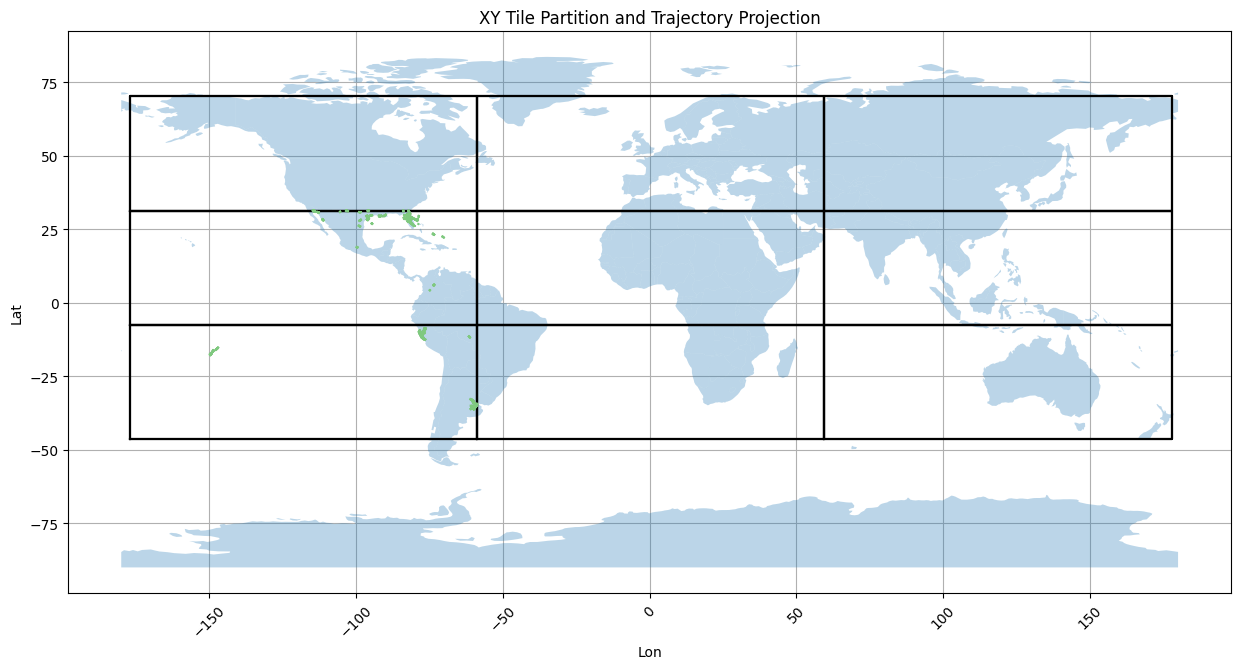

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# dfpoint = datardd.toDF(['partitionKey', 'Point'])
trajectoriesPartMap.printSchema()

# Create a bounding box
# bounding_box = box(bounds.xmin(), bounds.ymin(), bounds.xmax(), bounds.ymax())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, alpha=0.3)
#print(grid)
gridstr = [row.tile.__str__() for row in grid.collect()]

colors = plt.cm.Accent(np.linspace(0, 1, len(gridstr)))
# Adding an alpha value when creating the color ma<p
alpha_value = 1.0
color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, tile in enumerate(gridstr)}
for i, tilestr in enumerate(gridstr):
    tile: STBox = STBoxWrap(tilestr).set_srid(0)
    tile.plot_xy(axes=ax, color="black", draw_filling=False)

for idx, row in enumerate(trajectoriesPartMap.limit(2000).toLocalIterator()):
    traj = row.trajectory
    #print(traj)
    #if type(point)==str:
    #    point = TGeogPointInst(point)
    #tpointseq = point.to_sequence(interp).plot(axes=ax,label="tpoint", color=color_map[row.partitionKey % gp.num_partitions()], facecolors='none')
    traj.plot(axes=ax,label="trajectory", color=color_map[row.partitionKey % gp.num_partitions()], show_markers=False, ms=1)
plt.title("XY Tile Partition and Trajectory Projection")
plt.xlabel("Lon")
plt.ylabel("Lat")

In [15]:
"""
import pandas as pd
from functools import reduce
from pymeos import *
import pickle
from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.partitions.grid.grid_partitioner import *


pymeos_initialize("UTC")
#point = TGeogPointSeq('SRID=4326;[POINT(-96.93 41.61)@2022-06-27 00:00:55+00)')
#print(point)
tseq = TGeogPointSeq(string='SRID=4326;[POINT(-81.5 28.73)@2022-06-27 00:00:10+00, POINT(-81.5 28.72)@2022-06-27 00:00:20+00, POINT(-81.48 28.7)@2022-06-27 00:00:40+00, POINT(-81.48 28.69)@2022-06-27 00:00:50+00, POINT(30.45 -70.02)@2022-06-27 00:00:55+00)')
print(tseq.srid())
#tseq = tseq.set_srid(0)
bounds = STBox(
        "STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])").set_srid(0)
gp = GridPartition(cells_per_side=3, bounds=bounds)
print(gp.gridstr)
grid = [STBox(f"SRID=4326;GEOD{tile.__str__().replace('GEOD', '').replace('SRID=4326;', '')}") for tile in gp._generate_grid(bounds, 3, geodetic=True)]
for tile in grid:
    print(tile, tile.srid())
for key, tile in enumerate(grid):
    if tseq.at(tile) is not None:
        print("Attempting: ", key, tseq.at(tile))
"""

'\nimport pandas as pd\nfrom functools import reduce\nfrom pymeos import *\nimport pickle\nfrom pysparkmeos.UDT.MeosDatatype import *\nfrom pysparkmeos.partitions.grid.grid_partitioner import *\n\n\npymeos_initialize("UTC")\n#point = TGeogPointSeq(\'SRID=4326;[POINT(-96.93 41.61)@2022-06-27 00:00:55+00)\')\n#print(point)\ntseq = TGeogPointSeq(string=\'SRID=4326;[POINT(-81.5 28.73)@2022-06-27 00:00:10+00, POINT(-81.5 28.72)@2022-06-27 00:00:20+00, POINT(-81.48 28.7)@2022-06-27 00:00:40+00, POINT(-81.48 28.69)@2022-06-27 00:00:50+00, POINT(30.45 -70.02)@2022-06-27 00:00:55+00)\')\nprint(tseq.srid())\n#tseq = tseq.set_srid(0)\nbounds = STBox(\n        "STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])").set_srid(0)\ngp = GridPartition(cells_per_side=3, bounds=bounds)\nprint(gp.gridstr)\ngrid = [STBox(f"SRID=4326;GEOD{tile.__str__().replace(\'GEOD\', \'\').replace(\'SRID=4326;\', \'\')}") for tile in 